In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from matplotlib.patches import Patch

In [2]:
def rename_keys_by_map(d, key_map):
    """
    Renames keys in a dictionary using a mapping from old to new keys.

    Args:
        d (dict): Original dictionary.
        key_map (dict): Mapping from old keys to new keys.

    Returns:
        dict: Dictionary with renamed keys.
    """
    return {key_map.get(k, k): v for k, v in d.items()}

def reorder_dict(d, key_order):
    """
    Returns a new dict with keys ordered as specified in key_order.

    Args:
        d (dict): The original dictionary.
        key_order (list): Desired order of keys.

    Returns:
        dict: Reordered dictionary.
    """
    return {k: d[k] for k in key_order if k in d}

In [3]:
data_path = '/data/willett_data/paper_results/'

In [4]:
with open(data_path + 'blue_bar_comp.pkl', 'rb') as f:
    main_results = pickle.load(f)
    
with open(data_path + 'blue_bar_val.pkl', 'rb') as f:
    main_results_val = pickle.load(f)
    
with open(data_path + 'grey_bar_comp.pkl', 'rb') as f:
    ablation_results = pickle.load(f)
    
with open(data_path + 'grey_bar_dict.pkl', 'rb') as f:
    ablation_results_val = pickle.load(f)

In [5]:
main_results['neurips_gru_data_log_time_masked_lr_schedule_seed_']

[12.56, 11.883, 12.654, 12.424, 12.979, 11.937, 12.735, 12.884, 12.708]

In [9]:
main_results.keys()
remapped_keys_main = {'neurips_gru_baseline_seed_seed_': 'GRU (Baseline)', 
                 'neurips_gru_datalog_lr_scheduler_seed_': 'GRU + LR↓ + Log(x)', 
                 'neurips_gru_data_log_time_masked_lr_schedule_seed_': 'GRU + LR↓ + Log(x) + Mask',
                 'neurips_transformer_time_masked_seed_': 'Transf. + LR↓ + Log(x) + Mask'}
model_perf_dict_main = rename_keys_by_map(main_results, remapped_keys_main)

key_to_switch_ablation = ['No Log(x)', 'No LR↓', 'Sinusodial Pos. Emb.', 'No Mask']
orig_ablation_keys = list(ablation_results_val.keys())
remapped_keys_ablation = {}
for new_key, old_key in zip(key_to_switch_ablation, orig_ablation_keys):
    remapped_keys_ablation[old_key] = new_key

model_perf_dict_ablate = rename_keys_by_map(ablation_results, remapped_keys_ablation)


In [10]:
print(np.mean(model_perf_dict_main['Transf. + LR↓ + Log(x) + Mask']))
print(np.mean(model_perf_dict_main['GRU (Baseline)']))

12.271
15.276444444444444


# Figure 1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(0)

# -----------------------------
# Data for main models
# -----------------------------
model_order_main = list(model_perf_dict_main.keys())

data_main = pd.DataFrame([
    {"Model": m, "Performance": p} for m, ps in model_perf_dict_main.items() for p in ps
])
data_main["Model"] = pd.Categorical(data_main["Model"], categories=model_order_main, ordered=True)
means_main = data_main.groupby("Model")["Performance"].mean().reset_index()

# -----------------------------
# Data for ablations
# -----------------------------
model_order_ablate = ['No Log(x)', 'No LR↓', 'Sinusodial Pos. Emb.', 'No Mask']

data_ablate = pd.DataFrame([
    {"Model": m, "Performance": p} for m, ps in model_perf_dict_ablate.items() for p in ps
])
data_ablate["Model"] = pd.Categorical(data_ablate["Model"], categories=model_order_ablate, ordered=True)
means_ablate = data_ablate.groupby("Model")["Performance"].mean().reset_index()

# -----------------------------
# Plotting
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 3), sharex=False, sharey=False)
bar_color = "#6baed6"

# ---- Main models plot ----
for _, row in means_main.iterrows():
    axes[0].barh(
        y=row["Model"],
        width=row["Performance"],
        color=bar_color,
        alpha=0.6,
        height=0.5,
        zorder=0,
    )
    axes[0].text(
        0.3,
        row["Model"],
        row["Model"],
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        weight='bold',
        zorder=3,
    )

sns.stripplot(
    data=data_main,
    y="Model",
    x="Performance",
    order=model_order_main,
    hue="Model",
    color='black',
    jitter=False,
    size=8,
    alpha=0.4,
    legend=False,
    zorder=2,
    ax=axes[0],
)

axes[0].set_title("Model Comparisons", fontsize=16, pad=8)
axes[0].set_xlabel("Word error rate (%)", fontsize=14)
axes[0].set_ylabel("")
axes[0].tick_params(labelsize=12)
axes[0].set_xlim(left=0)
axes[0].set_xticks([0, 5, 10, 15])
axes[0].grid(axis="x", linestyle="--", alpha=0.3)
sns.despine(left=True, ax=axes[0])

# ---- Ablation plot ----
for _, row in means_ablate.iterrows():
    axes[1].barh(
        y=row["Model"],
        width=row["Performance"],
        color='gray',
        alpha=0.6,
        height=0.5,
        zorder=0,
    )
    axes[1].text(
        0.3,
        row["Model"],
        row["Model"],
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        weight='bold',
        zorder=3,
    )

sns.stripplot(
    data=data_ablate,
    y="Model",
    x="Performance",
    order=model_order_ablate,
    hue="Model",
    color='black',
    jitter=False,
    size=8,
    alpha=0.4,
    legend=False,
    zorder=2,
    ax=axes[1],
)

axes[1].set_title("Leave-One-Out Ablations", fontsize=16, pad=8)
axes[1].set_xlabel("Word error rate (%)", fontsize=14)
axes[1].set_ylabel("")
axes[1].tick_params(labelsize=12)
axes[1].set_xlim(left=0)
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[1].set_xticks([0, 5, 10, 15, 20])
axes[1].grid(axis="x", linestyle="--", alpha=0.3)
axes[1].axvline(x=np.mean(model_perf_dict_main['Transf. + LR↓ + Log(x) + Mask']), 
                color="black", linestyle='--', linewidth=2)
sns.despine(left=True, ax=axes[1])
plt.savefig('figure_pdf/figure1/3_gram.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


NameError: name 'model_perf_dict_main' is not defined

# Figure 2

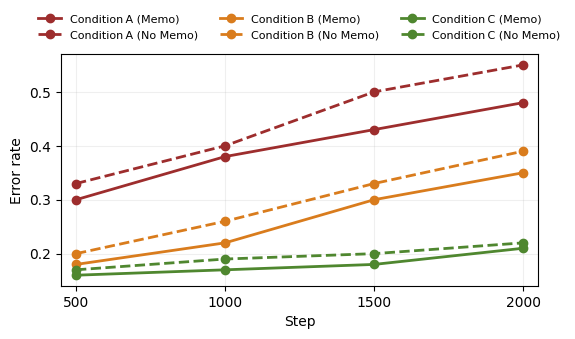

In [98]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Example data  -----------------------------------------------------
# Replace these lists with your real numbers
steps = [500, 1000, 1500, 2000]                # x–axis

memo_perf = {                                  # solid (lower) lines
    "Condition A": [0.30, 0.38, 0.43, 0.48],
    "Condition B": [0.18, 0.22, 0.30, 0.35],
    "Condition C": [0.16, 0.17, 0.18, 0.21],
}

no_memo_perf = {                               # dashed (upper) lines
    "Condition A": [0.33, 0.40, 0.50, 0.55],
    "Condition B": [0.20, 0.26, 0.33, 0.39],
    "Condition C": [0.17, 0.19, 0.20, 0.22],
}

# Consistent colours for each condition
palette = {
    "Condition A": "#9d2d2d",   # red‑ish
    "Condition B": "#d97c1d",   # orange
    "Condition C": "#4f872f",   # green
}
# ------------------------------------------------------------------


fig, ax = plt.subplots(figsize=(6, 3.5))

for cond, col in palette.items():
    # solid – Memo (lower)
    ax.plot(
        steps, memo_perf[cond],
        label=f"{cond} (Memo)",
        color=col, linestyle="-", marker="o", linewidth=2,
    )
    # dashed – No‑Memo (upper)
    ax.plot(
        steps, no_memo_perf[cond],
        label=f"{cond} (No Memo)",
        color=col, linestyle="--", marker="o", linewidth=2,
    )

# Cosmetics ---------------------------------------------------------
ax.set_xlabel("Step")
ax.set_ylabel("Error rate")
ax.set_xticks(steps)
ax.set_xlim(min(steps) - 50, max(steps) + 50)
ax.grid(alpha=0.2)

# Put legend above the plot, shrink font a bit
ax.legend(ncol=3, fontsize=8, loc="lower center",
          bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.tight_layout()
plt.show()
